In [ ]:
import re
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from datetime import datetime

log_pattern = re.compile(
    r'(?P<ip>\S+) \S+ \S+ '
    r'\[(?P<time>[^\]]+)\] '
    r'"(?P<method>\S+) (?P<url>\S+) (?P<protocol>[^"]+)" '
    r'(?P<status>\d+) (?P<bytes>\S+) '
    r'"(?P<referer>[^"]*)" '
    r'"(?P<user_agent>[^"]*)"'
)

rows = []
CHUNK_SIZE = 500_000

with open("access.log", "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        m = log_pattern.search(line)
        if not m:
            continue

        d = m.groupdict()

        rows.append({
            "ip": d["ip"],
            "timestamp": datetime.strptime(d["time"], "%d/%b/%Y:%H:%M:%S %z"),
            "method": d["method"],
            "url": d["url"],
            "protocol": d["protocol"],
            "status": int(d["status"]),
            "bytes": int(d["bytes"]) if d["bytes"].isdigit() else 0,
            "referer": d["referer"],
            "user_agent": d["user_agent"]
        })

        if len(rows) >= CHUNK_SIZE:
            df = pd.DataFrame(rows)
            table = pa.Table.from_pandas(df, preserve_index=False)

            pq.write_to_dataset(
                table,
                root_path="parquet_logs",
                partition_cols=["method"]
            )

            rows.clear()

# write remaining rows
if rows:
    df = pd.DataFrame(rows)
    table = pa.Table.from_pandas(df, preserve_index=False)
    pq.write_to_dataset(
        table,
        root_path="parquet_logs",
        partition_cols=["method"]
    )

print("Parquet conversion completed.")


In [ ]:
import pandas as pd
df = pd.read_parquet("parquet_logs")
df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
STATIC_EXTENSIONS = (
    ".css", ".js", ".png", ".jpg", ".jpeg",
    ".gif", ".svg", ".ico", ".woff", ".woff2",
    ".ttf", ".map"
)
df = df[~df["url"].str.lower().str.endswith(STATIC_EXTENSIONS)]
NOISE_PATTERNS = (
    "/notifications",
    "/heartbeat",
    "/poll",
    "/sync",
    "/status"
)

df = df[~df["url"].str.contains("|".join(NOISE_PATTERNS), case=False, na=False)]
from urllib.parse import urlparse

df["url_path"] = df["url"].apply(lambda x: urlparse(x).path)
df["method"] = df["method"].str.upper()
df["status_class"] = df["status"] // 100
df["ua_lower"] = df["user_agent"].str.lower()

df["is_headless"] = df["ua_lower"].str.contains("headless|phantom|selenium", na=False)
df["is_browser"] = df["ua_lower"].str.contains("mozilla|chrome|firefox|safari", na=False)
df["is_scripted"] = ~df["is_browser"]
df = df.sort_values("timestamp").reset_index(drop=True)
df.to_parquet("parquet_logs_cleaned", index=False)



# EDA

(8188933, 15)
              ip                 timestamp  \
0   54.36.149.41 2019-01-22 00:26:14+00:00   
1    31.56.96.51 2019-01-22 00:26:16+00:00   
2    31.56.96.51 2019-01-22 00:26:16+00:00   
3  40.77.167.129 2019-01-22 00:26:17+00:00   
4    91.99.72.15 2019-01-22 00:26:17+00:00   

                                                 url  protocol  status  bytes  \
0  /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%DB%8C...  HTTP/1.1     200  30577   
1                  /image/60844/productModel/200x200  HTTP/1.1     200   5667   
2                  /image/61474/productModel/200x200  HTTP/1.1     200   5379   
3                  /image/23488/productModel/150x150  HTTP/1.1     200   2654   
4  /product/31893/62100/%D8%B3%D8%B4%D9%88%D8%A7%...  HTTP/1.1     200  41483   

                               referer  \
0                                    -   
1  https://www.zanbil.ir/m/filter/b113   
2  https://www.zanbil.ir/m/filter/b113   
3                                    -   
4           

is_scripted
False    7910884
True      278049
Name: count, dtype: int64

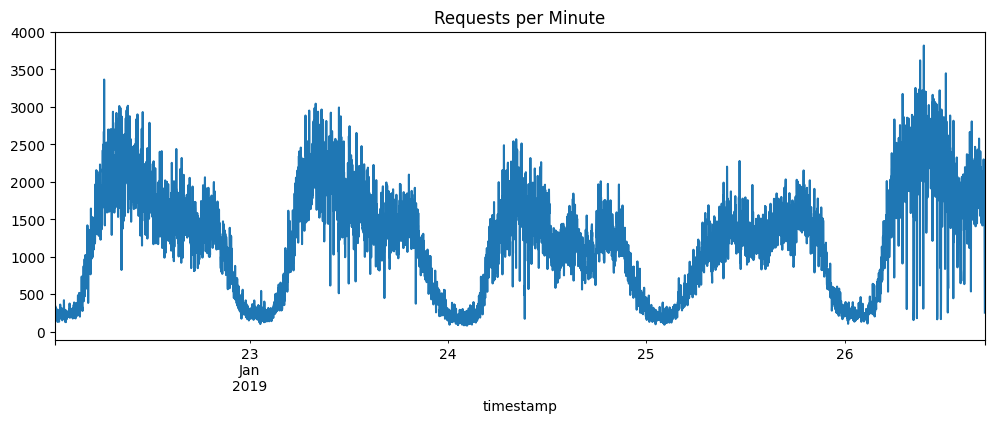

In [7]:
import pandas as pd

df = pd.read_parquet("parquet_logs_cleaned")

print(df.shape)
print(df.head())
print(df.dtypes)
df.set_index("timestamp").resample("1min").size().plot(
    title="Requests per Minute",
    figsize=(12,4)
)
df["ip"].value_counts().head(10)
df["method"].value_counts()
df["status"].value_counts().sort_index()
df["status_class"].value_counts().sort_index()
df["url_path"].value_counts().head(15)
df["is_headless"].value_counts()
df["is_scripted"].value_counts()
